## Семинар: "Методы оптимизации"

In [50]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем реализовать и сравнить различные методы оптимизации: SGD, Momentum, NAG, Adagrad, RMSProp, AdaDelta.

### Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [51]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

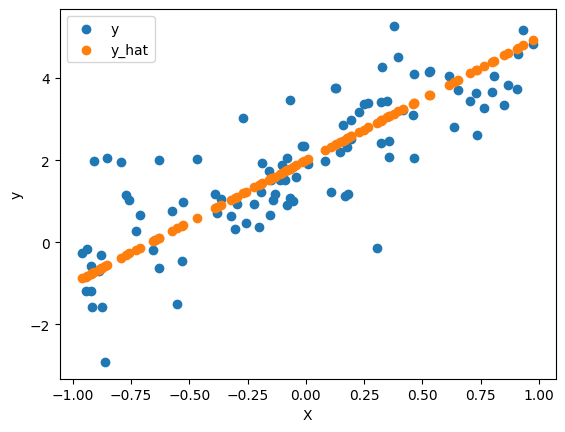

In [52]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

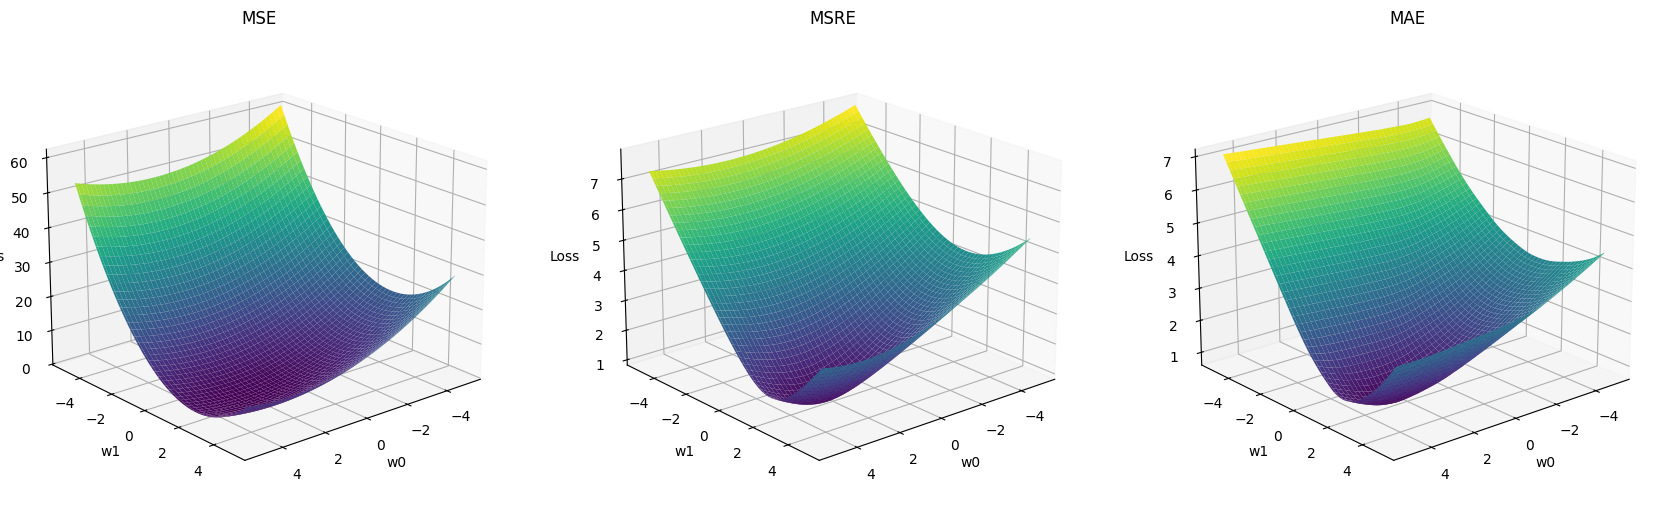

In [53]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [54]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [55]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [56]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in tqdm(optim_list):
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

#### SGD
$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_{i} (\theta_{t-1})$$

In [57]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


#### Momentum
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [58]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= self.prev_momentum[i]

#### Nesterov Accelerated Gradient (NAG)
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1} - \gamma \nu_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [59]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.prev_momentum[i] - self.gamma * prev_momentum

#### AdaGrad
$$G_t = \sum_{k=0}^t g_{k}^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [60]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += p.grad ** 2
                p -= self.eta * p.grad / torch.sqrt(self.G[i] + self.epsilon)

#### RMSProp
$$G_t = \gamma G_{t-1} + (1 - \gamma) g_t^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [61]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]


    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

In [62]:
from functools import partial

points, losses = optimize_function(
    partial(loss_animator.loss_func, loss=mse),
    SGD,
     {'lr': 1e-2},
    start_point=[-4, -4],
    num_iter=100
)

In [63]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', NAG, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta' : 1}],
        ['RMSProp', RMSProp, {'eta' : 1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

100%|██████████| 5/5 [00:00<00:00, 141.48it/s]


###  Домашнее задание: Обучение нейронной сети + Подбор шага

В этом задании вам нужно:
1) Реализовать Adam, AdamW и обучить сверточную нейросеть на MNIST. Сравнить графики обучения для SGD, Adam и AdamW. **(2 балла)**
2) Реализовать LinearLR и CosineAnnealingLR. Обучить сверточную нейросеть на MNIST с SGD, Adam, AdamW с LinearLR, CosineAnnealingLR. Сравните графики изменения loss-функции и точности (суммарно должно быть 9 экспериментов, 3 из которых покрываются пунктом 1). **(3 балла)**

Ссылки:
- https://arxiv.org/abs/1711.05101 (AdamW, статья)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html (AdamW, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html (LinearLR, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html (CosineAnnealingLR, PyTorch)

### Часть 1

#### Реализация Adam и AdamW

In [64]:
import torch

class Adam(Optimizer):
  def __init__(self, params, lr = 1e-3, beta1 = 0.9, beta2 = 0.999, eps = 1e-7, weight_decay = 0.0):
    super().__init__(params)
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.eps = eps
    self.weight_decay = weight_decay

    # Первый и второй момент
    self.m_list = [torch.zeros_like(p) for p in self.params]
    self.s_list = [torch.zeros_like(p) for p in self.params]
    self.t = 0 # номер итерации
  
  def step(self):
    self.t += 1
    wd = self.weight_decay

    with torch.no_grad():
      for i,p in enumerate(self.params):
        if p.grad is None:
          continue

        grad = p.grad # градиент текущего параметра

        if wd != 0.0:
          grad += wd*p

        m = self.m_list[i]
        s = self.s_list[i]

        m = self.beta1 * m + (1 - self.beta1) * grad
        s = self.beta2 * s + (1 - self.beta2) * grad * grad

        # Поправки на моменты
        m_modify = m / (1 - self.beta1 ** self.t)
        s_modify = s / (1 - self.beta2 ** self.t)

        step_update = self.lr * m_modify / (s_modify**0.5 + self.eps)

        p -= step_update

        self.m_list[i] = m
        self.s_list[i] = s

In [65]:
class AdamW(Optimizer):
  def __init__(self, params, lr = 1e-3, beta1 = 0.9, beta2 = 0.999, eps = 1e-7, weight_decay = 0.0):
    super().__init__(params)
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.eps = eps
    self.weight_decay = weight_decay

    self.m_list = [torch.zeros_like(p) for p in self.params]
    self.s_list = [torch.zeros_like(p) for p in self.params]

    self.t = 0

  def step(self):
    self.t += 1
    wd = self.weight_decay

    with torch.no_grad():
      for i,p in enumerate(self.params):
        if p.grad is None:
          continue

        grad = p.grad
        m = self.m_list[i]
        s = self.s_list[i]
        
        m = self.beta1 * m + (1 - self.beta1) * grad
        s = self.beta2 * s + (1 - self.beta2) * grad * grad

        # Поправки на моменты
        m_modify = m / (1 - self.beta1 ** self.t)
        s_modify = s / (1 - self.beta2 ** self.t)

        if wd != 0.0:
          p *= (1 - self.lr * wd)

        step_update = self.lr * m_modify / (s_modify**0.5 + self.eps)

        p -= step_update

        self.m_list[i] = m
        self.s_list[i] = s
        

#### Подготовка и обучение CNN

In [66]:
import torch, torchvision, torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import random
import numpy as np
import matplotlib.pyplot as plt


In [67]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [68]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [69]:
mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_test = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

valid_len = 10_000
mnist_valid = Subset(mnist_train, torch.arange(valid_len))
mnist_train_sub = Subset(mnist_train, torch.arange(valid_len, len(mnist_train)))

batch_size = 128
train_loader = DataLoader(mnist_train_sub, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True)
valid_loader = DataLoader(mnist_valid,      batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(mnist_test,       batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True)

In [70]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(3136, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )
    def forward(self, x):
        return self.net(x)

def build_model():
    model = SimpleCNN()
    return model

In [71]:
def train(model, num_epochs, train_data, valid_data, optimizer, loss_func):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_data:
            pred = model(x_batch)
            loss = loss_func(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            pred_value = torch.argmax(pred, dim=1)
            is_correct = (pred_value == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_data.dataset)
        accuracy_hist_train[epoch] /= len(train_data.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_data:
                pred = model(x_batch)
                loss = loss_func(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                pred_value = torch.argmax(pred, dim=1)
                is_correct = (pred_value == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()

        loss_hist_valid[epoch] /= len(valid_data.dataset)
        accuracy_hist_valid[epoch] /= len(valid_data.dataset)

        print(
            f"[{epoch+1}/{num_epochs}] Точность: {accuracy_hist_train[epoch]:.4f}, "
            f"val_accuracy: {accuracy_hist_valid[epoch]:.4f}"
        )

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [72]:
import matplotlib.pyplot as plt
from copy import deepcopy
base = build_model()
init_state = deepcopy(base.state_dict())

optimizers = {
    'SGD': lambda params: torch.optim.SGD(params, lr=1e-3, momentum=0.9, weight_decay=1e-2),
    'Adam': lambda params: Adam(params, lr=1e-3, weight_decay=0.0),
    'AdamW': lambda params: AdamW(params, lr=1e-3, weight_decay=1e-2)
}

results = {}
num_epochs = 10
loss_func = nn.CrossEntropyLoss()

for name, opt_fn in optimizers.items():
    print(f"\n====== {name} ======")
    model = build_model()
    model.load_state_dict(init_state)
    optimizer = opt_fn(model.parameters())
    result = train(model, num_epochs, train_loader, valid_loader, optimizer, loss_func)
    results[name] = result


====== SGD ======


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[1/10] Точность: 0.7745, val_accuracy: 0.9109
[2/10] Точность: 0.9234, val_accuracy: 0.9367
[3/10] Точность: 0.9449, val_accuracy: 0.9527
[4/10] Точность: 0.9576, val_accuracy: 0.9580
[5/10] Точность: 0.9646, val_accuracy: 0.9673
[6/10] Точность: 0.9692, val_accuracy: 0.9708
[7/10] Точность: 0.9723, val_accuracy: 0.9705
[8/10] Точность: 0.9747, val_accuracy: 0.9758
[9/10] Точность: 0.9769, val_accuracy: 0.9736
[10/10] Точность: 0.9778, val_accuracy: 0.9760

====== Adam ======
[1/10] Точность: 0.9572, val_accuracy: 0.9842
[2/10] Точность: 0.9867, val_accuracy: 0.9838
[3/10] Точность: 0.9923, val_accuracy: 0.9884
[4/10] Точность: 0.9937, val_accuracy: 0.9893
[5/10] Точность: 0.9955, val_accuracy: 0.9893
[6/10] Точность: 0.9957, val_accuracy: 0.9868
[7/10] Точность: 0.9972, val_accuracy: 0.9884
[8/10] Точность: 0.9967, val_accuracy: 0.9896
[9/10] Точность: 0.9981, val_accuracy: 0.9888
[10/10] Точность: 0.9976, val_accuracy: 0.9859

====== AdamW ======
[1/10] Точность: 0.9552, val_accuracy

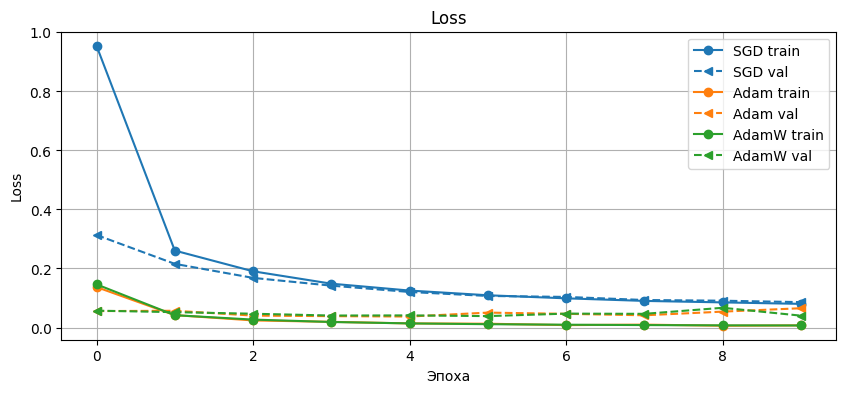

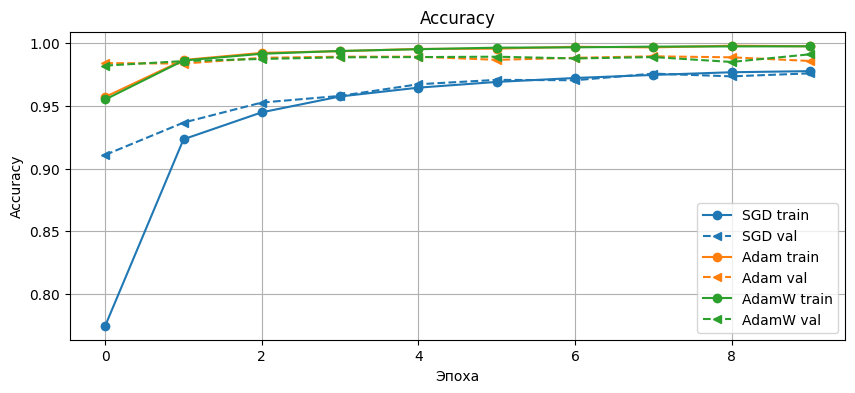

In [73]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
names = list(results.keys())

plt.figure(figsize=(10,4))
for i, name in enumerate(names):
    c = colors[i % len(colors)]
    train_loss, val_loss = results[name][0], results[name][1]
    plt.plot(train_loss, '-o',  color=c, label=f'{name} train')
    plt.plot(val_loss,  '--<', color=c, label=f'{name} val')
plt.title('Loss'); plt.xlabel('Эпоха'); plt.ylabel('Loss'); plt.legend(); plt.grid()

plt.figure(figsize=(10,4))
for i, name in enumerate(names):
    c = colors[i % len(colors)]
    train_acc, val_acc = results[name][2], results[name][3]
    plt.plot(train_acc, '-o',  color=c, label=f'{name} train')
    plt.plot(val_acc,  '--<', color=c, label=f'{name} val')
plt.title('Accuracy'); plt.xlabel('Эпоха'); plt.ylabel('Accuracy'); plt.legend(); plt.grid()
plt.show()

#### Вывод

1. AdamW показывает наилучшие результаты
	- Уже на первой эпохе достигает val accuracy ≈ 0.98.
	- Быстро выходит на плато по loss < 0.05, как на обучении, так и на валидации.

2. Adam также быстро сходится
	- Существенно обгоняет SGD по скорости обучения.
	-	Немного хуже обобщает, чем AdamW — на графике видна чуть большая разница между train и val.

3. SGD обучается медленнее
	-	Требует больше эпох, чтобы достичь той же точности (на 10-й эпохе ещё не вышел на точность Adam/AdamW)
	- С хорошей настройкой learning rate и scheduler потенциально может догнать Adam по обобщению (но за большее время).

### Часть 2

In [74]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer):
        self.optimizer = optimizer
        
        self.base_lr = optimizer.lr
        self.last_iter = -1

    def step(self):
        pass

In [75]:
import math

class LinearLR(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        start_factor: float = 0.1,
        end_factor: float = 1.0,
        total_iters: int = 100
    ):
        super().__init__(optimizer)
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = int(total_iters)

    def step(self):
        self.last_iter += 1
        t = min(self.last_iter, self.total_iters)
        factor = self.start_factor + (self.end_factor - self.start_factor) * (t / self.total_iters)
        self.optimizer.lr = self.base_lr * factor
        

class CosineAnnealing(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        T_max: int = 20,
        eta_min: float = 0.01
    ):
        super().__init__(optimizer)
        self.T_max = T_max
        self.eta_min = eta_min

    def step(self):
        self.last_iter += 1
        t = min(self.last_iter, self.T_max)
        lr = self.eta_min + 0.5 * (self.base_lr - self.eta_min) * (1.0 + math.cos(math.pi * t / self.T_max))
        self.optimizer.lr = lr

Модифицируем уже известную нам функцию train, добавив шаг шедулера в конце эпохи

In [76]:
def train(model, num_epochs, train_data, valid_data, optimizer, loss_func, scheduler=None):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_data:
            pred = model(x_batch)
            loss = loss_func(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            pred_value = torch.argmax(pred, dim=1)
            is_correct = (pred_value == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_data.dataset)
        accuracy_hist_train[epoch] /= len(train_data.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_data:
                pred = model(x_batch)
                loss = loss_func(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                pred_value = torch.argmax(pred, dim=1)
                is_correct = (pred_value == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()

        loss_hist_valid[epoch] /= len(valid_data.dataset)
        accuracy_hist_valid[epoch] /= len(valid_data.dataset)

        # Шаг шедулера в конце эпохи
        if scheduler is not None:
            scheduler.step()

        print(
            f"[{epoch+1}/{num_epochs}] Точность: {accuracy_hist_train[epoch]:.4f}, "
            f"val_accuracy: {accuracy_hist_valid[epoch]:.4f}"
        )

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [77]:
base = build_model()
init_state = deepcopy(base.state_dict())

optimizers = {
    'SGD':  lambda params: SGD(params, lr=1e-3),
    'Adam': lambda params: Adam(params, lr=1e-3, weight_decay=0.0),
    'AdamW':lambda params: AdamW(params, lr=1e-3, weight_decay=1e-2),
}

def make_scheduler(name, optimizer, num_epochs):
    if name is None:
        return None
    if name == 'LinearLR':
        return LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=num_epochs)
    if name == 'Cosine':
        return CosineAnnealing(optimizer, T_max=num_epochs, eta_min=1e-4)
    raise ValueError(f"Unknown scheduler: {name}")

schedulers = [None, 'LinearLR', 'Cosine']

results = {}
num_epochs = 8
loss_func = nn.CrossEntropyLoss()

for opt_name, opt_fn in optimizers.items():
    for sch_name in schedulers:
        tag = opt_name if sch_name is None else f"{opt_name}+{sch_name}"
        print(f"\n====== {tag} ======")
        model = build_model()
        model.load_state_dict(init_state)
        optimizer = opt_fn(model.parameters())
        scheduler = make_scheduler(sch_name, optimizer, num_epochs)
        result = train(model, num_epochs, train_loader, valid_loader, optimizer, loss_func, scheduler=scheduler)
        results[tag] = result


====== SGD ======
[1/8] Точность: 0.4415, val_accuracy: 0.6887
[2/8] Точность: 0.7234, val_accuracy: 0.7533
[3/8] Точность: 0.7944, val_accuracy: 0.8261
[4/8] Точность: 0.8484, val_accuracy: 0.8663
[5/8] Точность: 0.8753, val_accuracy: 0.8866
[6/8] Точность: 0.8898, val_accuracy: 0.8995
[7/8] Точность: 0.8991, val_accuracy: 0.9044
[8/8] Точность: 0.9061, val_accuracy: 0.9121

====== SGD+LinearLR ======
[1/8] Точность: 0.4505, val_accuracy: 0.6726
[2/8] Точность: 0.7209, val_accuracy: 0.7591
[3/8] Точность: 0.7898, val_accuracy: 0.8211
[4/8] Точность: 0.8390, val_accuracy: 0.8555
[5/8] Точность: 0.8651, val_accuracy: 0.8734
[6/8] Точность: 0.8781, val_accuracy: 0.8865
[7/8] Точность: 0.8859, val_accuracy: 0.8915
[8/8] Точность: 0.8907, val_accuracy: 0.8950

====== SGD+Cosine ======
[1/8] Точность: 0.4621, val_accuracy: 0.6658
[2/8] Точность: 0.7239, val_accuracy: 0.7640
[3/8] Точность: 0.7924, val_accuracy: 0.8251
[4/8] Точность: 0.8438, val_accuracy: 0.8620
[5/8] Точность: 0.8698, val

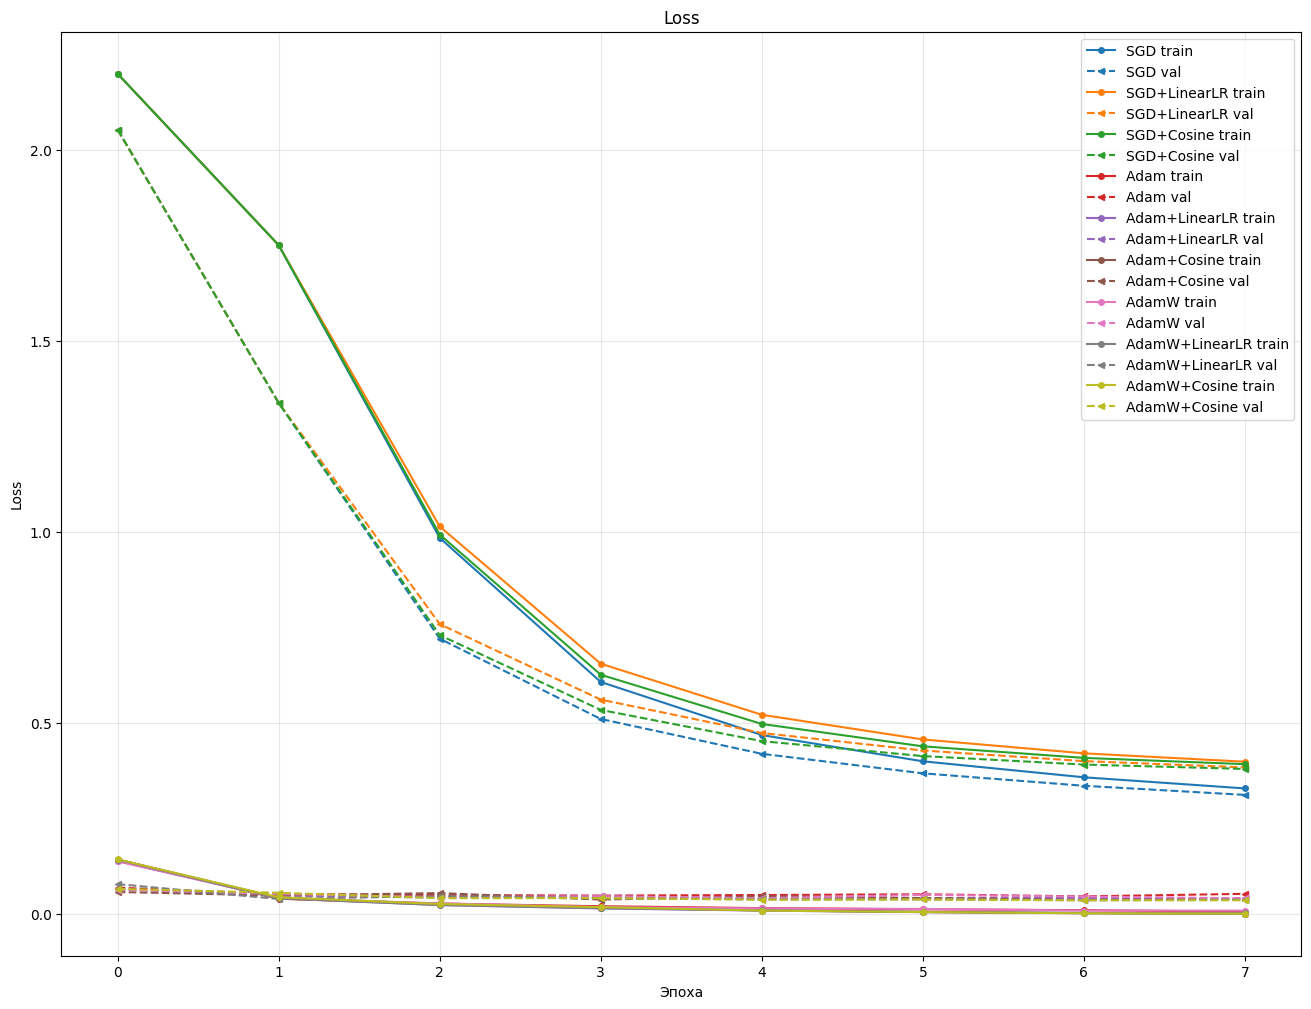

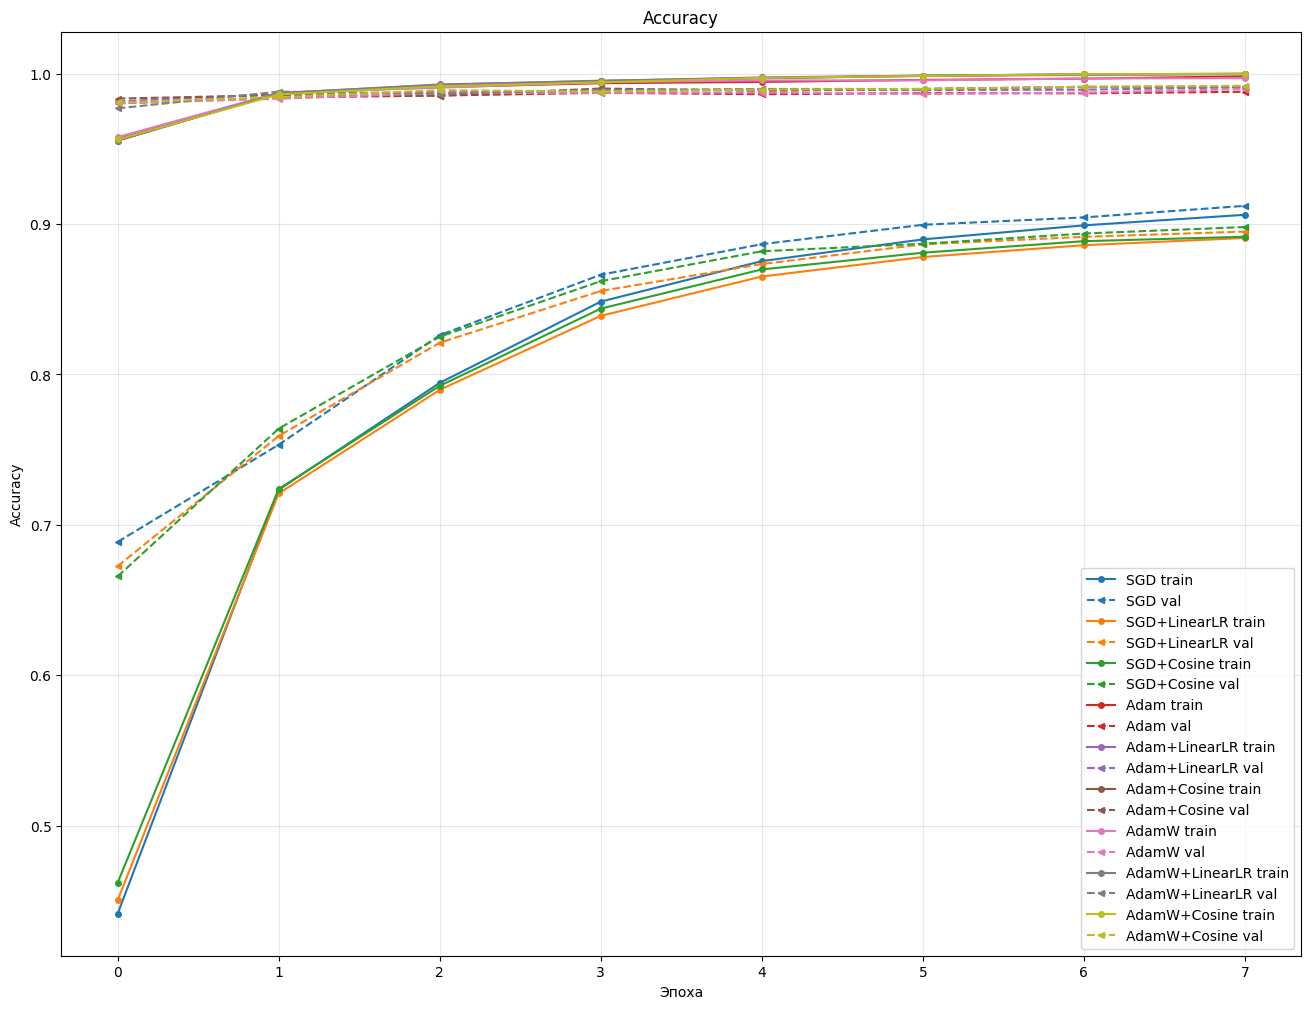

In [78]:
from matplotlib.lines import Line2D

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
names  = list(results.keys())

plt.figure(figsize=(16,12))

for i, name in enumerate(names):
    c = colors[i % len(colors)]
    train_loss, val_loss = results[name][0], results[name][1]
    plt.plot(train_loss, '-o',  linewidth=1.5, markersize=4, color=c, label=f'{name} train')
    plt.plot(val_loss,  '--<', linewidth=1.5, markersize=4, color=c, label=f'{name} val')

plt.title('Loss'); plt.xlabel('Эпоха'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, alpha=0.3)

plt.figure(figsize=(16,12))

for i, name in enumerate(names):
    c = colors[i % len(colors)]
    train_acc, val_acc = results[name][2], results[name][3]
    plt.plot(train_acc, '-o',  linewidth=1.5, markersize=4, color=c, label=f'{name} train')
    plt.plot(val_acc,  '--<', linewidth=1.5, markersize=4, color=c, label=f'{name} val')

plt.title('Accuracy'); plt.xlabel('Эпоха'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

#### Вывод

Наилучшие результаты были достигнуты при использовании оптимизаторов Adam и AdamW в сочетании с шедулером CosineAnnealing, что позволило достичь валидационной точности до 99.19% уже к 8-й эпохе. Базовый оптимизатор SGD показал значительно более низкую точность (около 91%) и существенно медленнее обучался. Добавление шедулеров к SGD не дало заметного прироста. 

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

- Your text here

Здесь вы можете оставить комментарии по лекции или семинару:

- Your text here